In [1]:
import tensorflow as tf
print(tf.__version__)

1.12.0


## testing for online resource (only for tf>=1.13)
https://github.com/Bisonai/mobilenetv3-tensorflow/blob/master/

In [ ]:
from mobilenetv3_factory import build_mobilenetv3
model = build_mobilenetv3(
    "large",
    input_shape=(224, 224, 3),
    num_classes=1001,
    width_multiplier=1.0,
)
model.summary()

In [2]:
from layers import Bneck

layer = Bneck(
      out_channels=16,
      exp_channels=16,
      kernel_size=3,
      stride=1,
      use_se=True,
      act_layer="relu",
     )

x = tf.keras.Input((5,5,16), name="x")
out = layer(x)
model = tf.keras.Model(inputs=[x], outputs=[out], name="test")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 5, 5, 16)          0         
_________________________________________________________________
Bneck (Bneck)                (None, 5, 5, 16)          976       
Total params: 976
Trainable params: 880
Non-trainable params: 96
_________________________________________________________________


## our block

In [75]:
"""
def ReLU6(inputs, name):
    return tf.keras.layers.ReLU(max_value=6, name=f"{name}/ReLU6") (inputs)

def HardSigmoid(inputs, name):
    out = inputs
    out = tf.keras.layers.Add(name=f"{name}/Add") ([out, 3.0])
    out = ReLU6(out, name=name)
    out = tf.keras.layers.Multiply(name=f"{name}/Div") ([inputs, 1/6.0])
    return out

def HardSwish(inputs, name):
    return tf.keras.layers.multiply(name=f"{name}/Mul") ([inputs, HardSigmoid(inputs, name=name)])

"""
class ReLU6(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__(name="ReLU6")
        self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6")

    def call(self, input):
        return self.relu6(input)


class HardSigmoid(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__(name="HardSigmoid")
        self.relu6 = ReLU6()

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0


class HardSwish(tf.keras.layers.Layer):
    def __init__(self, name="HardSwish"):
        super().__init__(name=name)
        self.hard_sigmoid = HardSigmoid()

    def call(self, input):
        return input * self.hard_sigmoid(input)


In [76]:
def BatchNormalization(inputs, name):
    return tf.keras.layers.BatchNormalization(momentum=0.99, name=name) (inputs)

def ConvNormAct(inputs, 
                filters, 
                kernel_size=3, 
                stride=1, 
                padding=0, 
                use_bn=False, 
                act_layer="relu", 
                use_bias=True, 
                l2_reg=1e-5, 
                name="ConvNormAct"):
    
    in_channels = inputs.get_shape()[-1]
    
    out = inputs
    
    if padding > 0:
        out = tf.keras.layers.ZeroPadding2D(padding=padding,
                                            name=f"{name}/padding",) (out)
    
    out = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=stride,
            name=f"{name}/conv{kernel_size}x{kernel_size}",
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            use_bias=use_bias,
        ) (out)
    
    if use_bn:
        out = BatchNormalization(out, name=f"{name}/bn")
    
    
    if act_layer:
        _available_activation = {
            "relu": tf.keras.layers.ReLU(name=f"{name}/ReLU"),
            "hswish": HardSwish(name=f"{name}/HardSwish"),
            "softmax": tf.keras.layers.Softmax(name=f"{name}/Softmax"),
        }
        out = _available_activation.get(act_layer) (out)
    
    return out

"""
x = tf.keras.Input((5,5,3), name="x")
out = ConvNormAct(x, 16, 3, 2, 1, True, "relu", False, 1e-5)
model = tf.keras.Model(inputs=[x], outputs=[out], name="test")
model.summary()
"""

'\nx = tf.keras.Input((5,5,3), name="x")\nout = ConvNormAct(x, 16, 3, 2, 1, True, "relu", False, 1e-5)\nmodel = tf.keras.Model(inputs=[x], outputs=[out], name="test")\nmodel.summary()\n'

In [77]:
def GlobalAveragePooling2D(inputs, name):
    pool_size = inputs.get_shape()[1:3]
    gap = tf.keras.layers.AveragePooling2D(
        pool_size=pool_size,
        name=f"{name}/AvgPool{pool_size[0]}x{pool_size[1]}")
    return gap(inputs)
    
def SEBottleneck(inputs, 
                 reduction=4,
                 l2_reg=1e-2,
                 name="SEBottleneck"):
    batch_size = inputs.get_shape()[0]
    in_channels = inputs.get_shape()[-1]
    
    out = inputs
    
    gap = GlobalAveragePooling2D(out, name=f"{name}/gap")
    
    filters_squeeze = in_channels//reduction if in_channels//reduction > 0 else 1    
    conv1 = ConvNormAct(inputs=gap,
                        filters=int(filters_squeeze), 
                        kernel_size=1, 
                        use_bn=False,
                        act_layer="relu", 
                        use_bias=False, 
                        l2_reg=l2_reg, 
                        name=f"{name}/Squeeze")
    
    conv2 = ConvNormAct(inputs=conv1,
                        filters=int(in_channels), 
                        kernel_size=1, 
                        use_bn=False, 
                        act_layer="relu",
                        use_bias=False, 
                        l2_reg=l2_reg, 
                        name=f"{name}/Excite")
    
    return tf.keras.layers.Multiply(name=f"{name}/Mul") ([inputs, conv2]) 

"""
x = tf.keras.Input((5,5,16), name="x")
out = SEBottleneck(x, name="SEB")
model = tf.keras.Model(inputs=[x], outputs=[out], name="test")
model.summary()
"""

'\nx = tf.keras.Input((5,5,16), name="x")\nout = SEBottleneck(x, name="SEB")\nmodel = tf.keras.Model(inputs=[x], outputs=[out], name="test")\nmodel.summary()\n'

In [78]:
def myBneck(inputs, 
            out_channels, 
            exp_channels, 
            kernel_size, 
            stride, 
            use_se, 
            act_layer,
            l2_reg=1e-5,
            name="myBneck"):
    
    in_channels = inputs.get_shape()[-1]
    
    out = inputs
    
    # Expand -----------------
    out = ConvNormAct(
        inputs=out,
        filters=exp_channels,
        kernel_size=1,
        use_bn=True,
        act_layer=act_layer,
        use_bias=False,
        l2_reg=l2_reg,
        name=f"{name}/Expand",
    )
    
    # Depthwise -----------------
    dw_padding = (kernel_size - 1) // 2
    out = tf.keras.layers.ZeroPadding2D(
        padding=dw_padding,
        name=f"{name}/Depthwise/Padding{dw_padding}x{dw_padding}",
    ) (out)
    
    out = tf.keras.layers.DepthwiseConv2D(
        kernel_size=kernel_size,
        strides=stride,
        name=f"{name}/Depthwise/DWConv{kernel_size}x{kernel_size}",
        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
        use_bias=False,
    ) (out)
    
    out = BatchNormalization(out, name=f"{name}/Depthwise/bn")
    
    if use_se:
        out = SEBottleneck(inputs=out,
                           l2_reg=l2_reg,
                           name=f"{name}/Depthwise/SEBottleneck")

    _available_activation = {
        "relu": tf.keras.layers.ReLU(name=f"{name}/Depthwise/ReLU"),
        "hswish": HardSwish(name=f"{name}/HardSwish"),
    }
    out = _available_activation.get(act_layer) (out)
    
    # Project -----------------
    out = ConvNormAct(
        inputs=out,
        filters=out_channels,
        kernel_size=1,
        use_bn=True,
        act_layer=None,
        use_bias=False,
        l2_reg=l2_reg,
        name=f"{name}/Project",
    )
    
    if stride == 1 and in_channels == out_channels:
        out = tf.keras.layers.Add(name=f"{name}/Add") ([inputs, out])
    
    return out

In [6]:
x = tf.keras.Input((5,5,16), name="x")
#out = SEBottleneck(x, name="SEB")
out = myBneck(x, 16, 16, 3, 1, True, "relu")
model = tf.keras.Model(inputs=[x], outputs=[out], name="test")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 5, 5, 16)     0                                            
__________________________________________________________________________________________________
myBneck/Expand/conv1x1 (Conv2D) (None, 5, 5, 16)     256         x[0][0]                          
__________________________________________________________________________________________________
myBneck/Expand/bn (BatchNormali (None, 5, 5, 16)     64          myBneck/Expand/conv1x1[0][0]     
__________________________________________________________________________________________________
myBneck/Expand/ReLU (ReLU)      (None, 5, 5, 16)     0           myBneck/Expand/bn[0][0]          
__________________________________________________________________________________________________
myBneck/De

## train Cifar-10

In [5]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

num_classes = 10
input_shape = [32,32,3]

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


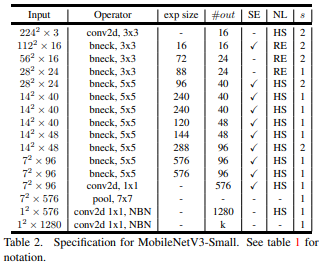

## with SE

In [46]:
inputs = tf.keras.Input(shape=input_shape, name='input')
out = inputs

divisor = 2
#                      oc          ks st pad  bn    act    bias
out = ConvNormAct(out, 16//divisor, 3, 2, 1, True, "relu", False, name="CB0")
#                  oc,          ec,         ks, st, se,  act
out = myBneck(out, 16//divisor, 16//divisor, 3, 2, True, "relu", name="MB0")
out = myBneck(out, 24//divisor, 72//divisor, 3, 2, True, "relu", name="MB1")
out = myBneck(out, 24//divisor, 88//divisor, 3, 1, True, "relu", name="MB2")

#out = mynet_block(out, 8, strides=2, name="RL0")
#out = mynet_block(out, 8, strides=1, name='RL1')
#out = mynet_block(out, 16, strides=2, name='RL2')
#out = mynet_block(out, 16, strides=1, name='RL3')
#out = mynet_block(out, 32, strides=2, name='RL4')
#out = mynet_block(out, 32, strides=1, name='RL5')

out = tf.keras.layers.GlobalAveragePooling2D(name='GAP')(out)
out = tf.keras.layers.Flatten(name='Flatten')(out)
out = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal', name='output')(out)

model = tf.keras.Model(inputs=inputs, outputs=out, name='Model')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
CB0/padding (ZeroPadding2D)     (None, 34, 34, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
CB0/conv3x3 (Conv2D)            (None, 16, 16, 8)    216         CB0/padding[0][0]                
__________________________________________________________________________________________________
CB0/bn (BatchNormalization)     (None, 16, 16, 8)    32          CB0/conv3x3[0][0]                
__________________________________________________________________________________________________
CB0/ReLU (

In [47]:
batch_size = 256
epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(1e-2, 0.9),
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(factor=0.5,
                              min_lr=1e-12,
                              monitor='loss',
                              patience=5,
                              verbose=1)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 142us/step - loss: 2.1169 - acc: 0.2114 - val_loss: 2.3219 - val_acc: 0.0993
Epoch 2/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.8247 - acc: 0.3057 - val_loss: 2.2752 - val_acc: 0.1822
Epoch 3/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6918 - acc: 0.3645 - val_loss: 1.9651 - val_acc: 0.2874
Epoch 4/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6187 - acc: 0.3941 - val_loss: 1.7499 - val_acc: 0.3539
Epoch 5/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.5587 - acc: 0.4200 - val_loss: 1.8072 - val_acc: 0.3679
Epoch 6/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.5039 - acc: 0.4483 - val_loss: 1.5469 - val_acc: 0.4385
Epoch 7/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.4516 - acc: 0.4699 - val_loss: 1.6112 - val_ac

## with SE

In [48]:
inputs = tf.keras.Input(shape=input_shape, name='input')
out = inputs

divisor = 2
#                      oc          ks st pad  bn    act    bias
out = ConvNormAct(out, 16//divisor, 3, 2, 1, True, "relu", False, name="CB0")
#                  oc,          ec,         ks, st,  se,   act
out = myBneck(out, 16//divisor, 16//divisor, 3, 2, False, "relu", name="MB0")
out = myBneck(out, 24//divisor, 72//divisor, 3, 2, False, "relu", name="MB1")
out = myBneck(out, 24//divisor, 88//divisor, 3, 1, False, "relu", name="MB2")

out = tf.keras.layers.GlobalAveragePooling2D(name='GAP')(out)
out = tf.keras.layers.Flatten(name='Flatten')(out)
out = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal', name='output')(out)

model = tf.keras.Model(inputs=inputs, outputs=out, name='Model')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
CB0/padding (ZeroPadding2D)     (None, 34, 34, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
CB0/conv3x3 (Conv2D)            (None, 16, 16, 8)    216         CB0/padding[0][0]                
__________________________________________________________________________________________________
CB0/bn (BatchNormalization)     (None, 16, 16, 8)    32          CB0/conv3x3[0][0]                
__________________________________________________________________________________________________
CB0/ReLU (

In [49]:
batch_size = 256
epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(1e-2, 0.9),
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(factor=0.5,
                              min_lr=1e-12,
                              monitor='loss',
                              patience=5,
                              verbose=1)

history_wo = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr])
score_wo = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_wo[0])
print('Test accuracy:', score_wo[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.8906 - acc: 0.3038 - val_loss: 2.6637 - val_acc: 0.1000
Epoch 2/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.6386 - acc: 0.3993 - val_loss: 1.8194 - val_acc: 0.3226
Epoch 3/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.5468 - acc: 0.4368 - val_loss: 1.5763 - val_acc: 0.4218
Epoch 4/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.4857 - acc: 0.4581 - val_loss: 1.6463 - val_acc: 0.4162
Epoch 5/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.4355 - acc: 0.4745 - val_loss: 1.4819 - val_acc: 0.4595
Epoch 6/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.4020 - acc: 0.4859 - val_loss: 1.5129 - val_acc: 0.4547
Epoch 7/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.3719 - acc: 0.4983 - val_loss: 1.4085 - val_ac

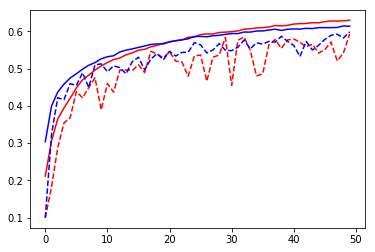

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history['acc'], 'r')
plt.plot(history.epoch, history.history['val_acc'], 'r--')
plt.plot(history_wo.epoch, history_wo.history['acc'], 'b')
plt.plot(history_wo.epoch, history_wo.history['val_acc'], 'b--')

# w SE , w hswish

In [79]:
inputs = tf.keras.Input(shape=input_shape, name='input')
out = inputs

divisor = 2
#                      oc          ks st pad  bn    act    bias
out = ConvNormAct(out, 16//divisor, 3, 2, 1, True, "hswish", False, name="CB0")
#                  oc,          ec,         ks, st, se,  act
out = myBneck(out, 16//divisor, 16//divisor, 3, 2, True, "relu", name="MB0")
out = myBneck(out, 24//divisor, 72//divisor, 3, 2, True, "relu", name="MB1")
out = myBneck(out, 24//divisor, 88//divisor, 3, 1, True, "relu", name="MB2")

#out = mynet_block(out, 8, strides=2, name="RL0")
#out = mynet_block(out, 8, strides=1, name='RL1')
#out = mynet_block(out, 16, strides=2, name='RL2')
#out = mynet_block(out, 16, strides=1, name='RL3')
#out = mynet_block(out, 32, strides=2, name='RL4')
#out = mynet_block(out, 32, strides=1, name='RL5')

out = tf.keras.layers.GlobalAveragePooling2D(name='GAP')(out)
out = tf.keras.layers.Flatten(name='Flatten')(out)
out = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal', name='output')(out)

model = tf.keras.Model(inputs=inputs, outputs=out, name='Model')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
CB0/padding (ZeroPadding2D)     (None, 34, 34, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
CB0/conv3x3 (Conv2D)            (None, 16, 16, 8)    216         CB0/padding[0][0]                
__________________________________________________________________________________________________
CB0/bn (BatchNormalization)     (None, 16, 16, 8)    32          CB0/conv3x3[0][0]                
__________________________________________________________________________________________________
CB0/HardSw

In [80]:
batch_size = 256
epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(1e-2, 0.9),
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(factor=0.5,
                              min_lr=1e-12,
                              monitor='loss',
                              patience=5,
                              verbose=1)

history_wh = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr])
score_wh = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_wh[0])
print('Test accuracy:', score_wh[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.2292 - acc: 0.1607 - val_loss: 2.3160 - val_acc: 0.1168
Epoch 2/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.9384 - acc: 0.2602 - val_loss: 2.2653 - val_acc: 0.1560
Epoch 3/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.7589 - acc: 0.3425 - val_loss: 1.7991 - val_acc: 0.3203
Epoch 4/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.6469 - acc: 0.3856 - val_loss: 2.0207 - val_acc: 0.3076
Epoch 5/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.5777 - acc: 0.4161 - val_loss: 2.1296 - val_acc: 0.3125
Epoch 6/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.5284 - acc: 0.4369 - val_loss: 1.6306 - val_acc: 0.4037
Epoch 7/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.4947 - acc: 0.4530 - val_loss: 1.5966 - val_ac

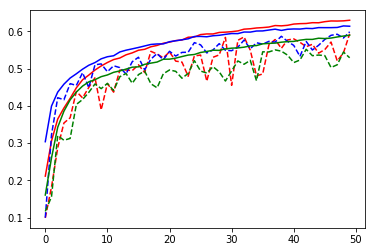

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history['acc'], 'r')
plt.plot(history.epoch, history.history['val_acc'], 'r--')
plt.plot(history_wo.epoch, history_wo.history['acc'], 'b')
plt.plot(history_wo.epoch, history_wo.history['val_acc'], 'b--')
plt.plot(history_wh.epoch, history_wh.history['acc'], 'g')
plt.plot(history_wh.epoch, history_wh.history['val_acc'], 'g--')